In [1]:
!pip install librosa

In [2]:
!pip install pydub

In [3]:
!pip install opencv-python

In [4]:
!pip install pillow

In [5]:
!pip install --upgrade tensorflow

In [6]:
#imports

import librosa
import numpy as np
import pandas as pd
from google.colab import drive
drive.mount('/content/drive') #this is done in the cloud using Google colab - Drive was used for the audio recordings, so data is imported with this
import glob
from sklearn.preprocessing import StandardScaler
from pydub import AudioSegment
import wave
import matplotlib.pyplot as plt
from os import path
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D
import tensorflow.keras.backend as K
from PIL import Image
import cv2
import sklearn.preprocessing as preprocessing
from sklearn.model_selection import train_test_split
import tensorflow as tf

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.37.133.58:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.37.133.58:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [8]:
#goes through the data and prints the different recording file names and locations

directory = "/content/drive/My Drive/note_classification_project/wave_converted"

arr = np.array([])

for filen in glob.iglob(f'{directory}/*'):
  arr = np.append(arr,str(filen))

df = pd.DataFrame(arr,columns=['name'])

df2 = pd.DataFrame(np.array(["6E","6E","6F","6F","6F#","6F#","6G","6G","5A","5A","5Bb","5Bb","5B","5B","5C","5C","4D","4D","4Eb","4Eb","4E","4E","4F","4F","3G","3G"]),columns=["String_Note"])
data = pd.concat([df,df2],axis=1)


#feature scaling to make data better
def scale(X):
  scaler = StandardScaler()

  X = scaler.fit_transform(X)

  return X

Convert the files to wav since it is easier to work with wav files - only run once!!!

In [9]:
"""

note_names = np.array(["6E1","6E2","6F1","6F2","6F#1","6F#2","6G1","6G2","5A1","5A2","5Bb1","5Bb2","5B1","5B2","5C1","5C2","4D1","4D2","4Eb1","4Eb2","4E1","4E2","4F1","4F2","3G1","3G2"])

count = 0
for filen in glob.iglob(f'{directory}/*'):

  m4a_file = filen

  new_file = "/content/drive/My Drive/note_classification_project/wav_converted" + str(note_names[count])

  count += 1

  track = AudioSegment.from_file(m4a_file,  format= 'm4a')

  file_handle = track.export(new_file, format='wav')

"""


'\n\nnote_names = np.array(["6E1","6E2","6F1","6F2","6F#1","6F#2","6G1","6G2","5A1","5A2","5Bb1","5Bb2","5B1","5B2","5C1","5C2","4D1","4D2","4Eb1","4Eb2","4E1","4E2","4F1","4F2","3G1","3G2"])\n\ncount = 0\nfor filen in glob.iglob(f\'{directory}/*\'):\n\n  m4a_file = filen\n\n  new_file = "/content/drive/My Drive/note_classification_project/wav_converted" + str(note_names[count])\n\n  count += 1\n\n  track = AudioSegment.from_file(m4a_file,  format= \'m4a\')\n\n  file_handle = track.export(new_file, format=\'wav\')\n\n'

In [10]:
for filen in glob.iglob(f'{directory}/*'):

  # Load files and view different features
  audio_segment = AudioSegment.from_file(filen)

  print("note is: ", filen[80:])

  print(f"Channels: {audio_segment.channels}")
  print(f"Sample width: {audio_segment.sample_width}")
  print(f"Frame rate (sample rate): {audio_segment.frame_rate}")
  print(f"Frame width: {audio_segment.frame_width}")
  print(f"Length (ms): {len(audio_segment)}")
  print(f"Frame count: {audio_segment.frame_count()}")
  print(f"Intensity: {audio_segment.dBFS}")
  print("_______________________________________")

note is:  3G2
Channels: 2
Sample width: 2
Frame rate (sample rate): 48000
Frame width: 4
Length (ms): 10795
Frame count: 518144.0
Intensity: -27.3864379856296
_______________________________________
note is:  6E1
Channels: 2
Sample width: 2
Frame rate (sample rate): 48000
Frame width: 4
Length (ms): 10389
Frame count: 498688.0
Intensity: -24.078159531170456
_______________________________________
note is:  6E2
Channels: 2
Sample width: 2
Frame rate (sample rate): 48000
Frame width: 4
Length (ms): 10475
Frame count: 502784.0
Intensity: -21.65923358378423
_______________________________________
note is:  6F1
Channels: 2
Sample width: 2
Frame rate (sample rate): 48000
Frame width: 4
Length (ms): 10517
Frame count: 504832.0
Intensity: -26.886175678626714
_______________________________________
note is:  6F2
Channels: 2
Sample width: 2
Frame rate (sample rate): 48000
Frame width: 4
Length (ms): 10709
Frame count: 514048.0
Intensity: -26.457649632463443
______________________________________

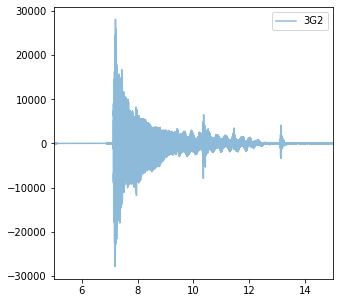

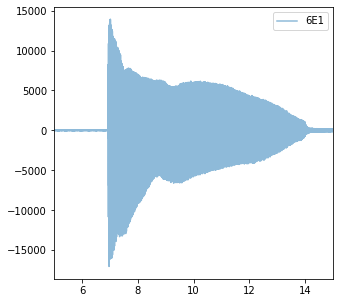

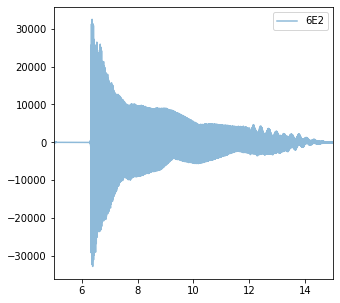

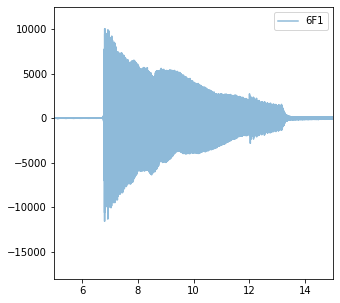

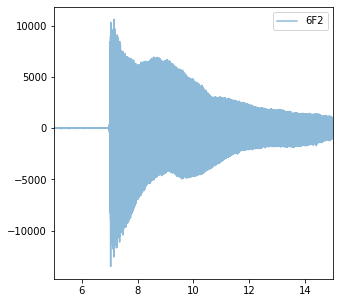

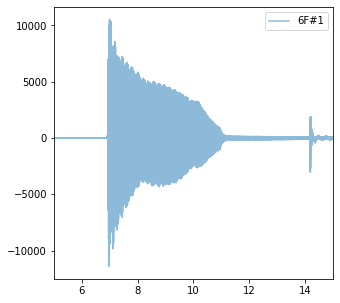

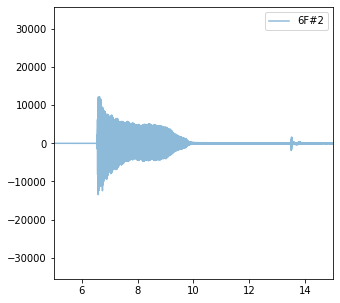

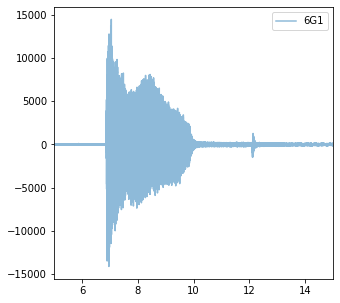

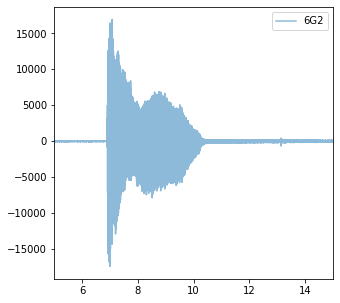

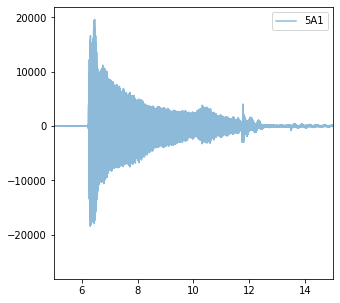

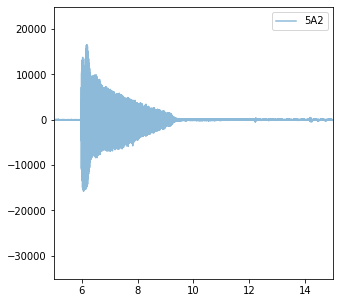

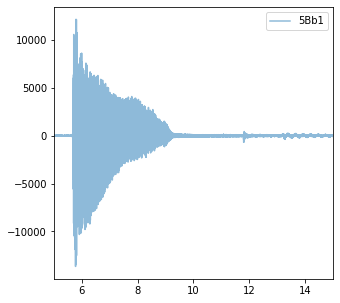

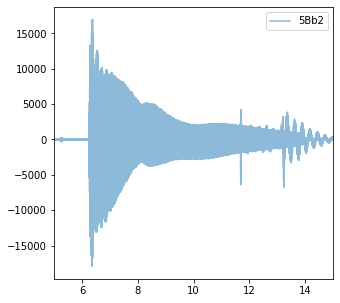

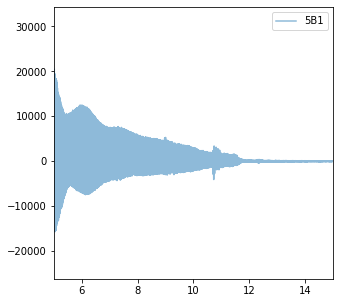

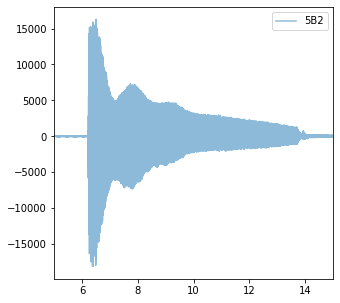

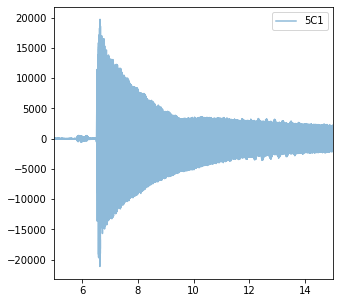

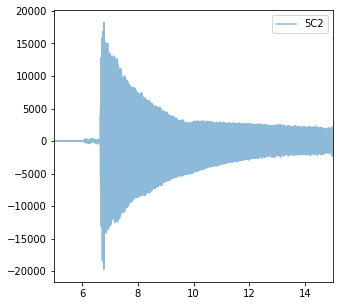

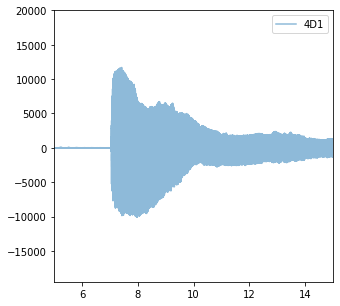

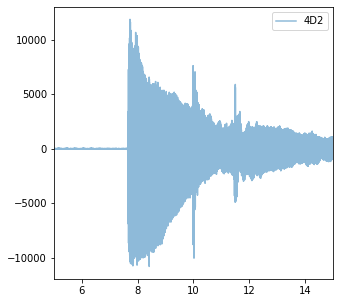

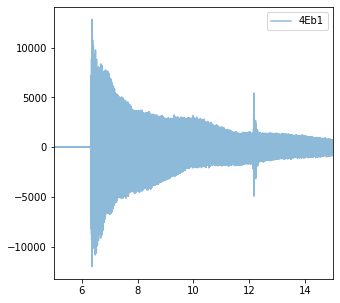

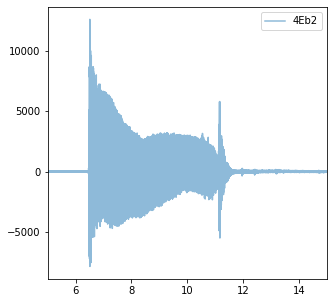

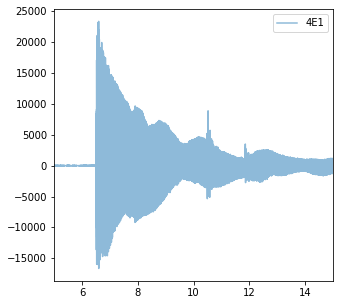

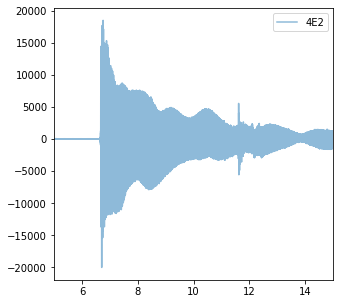

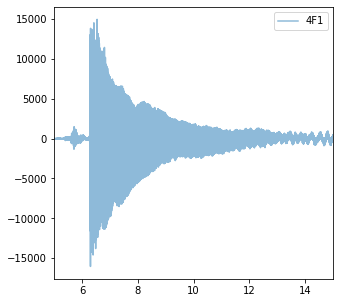

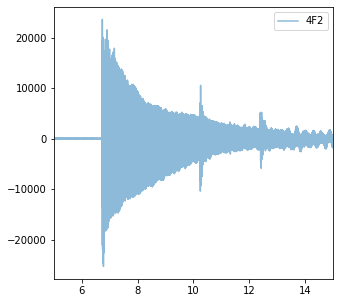

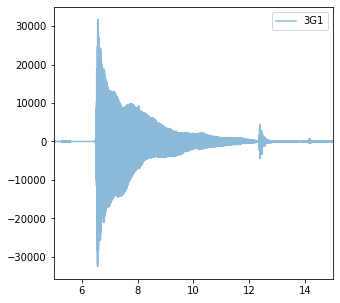

In [11]:
for filen in glob.iglob(f'{directory}/*'):


  # Open wav file and read frames as bytes
  sf_filewave = wave.open(filen, 'r')
  signal_sf = sf_filewave.readframes(-1)# Convert audio bytes to integers
  soundwave_sf = np.frombuffer(signal_sf, dtype='int16')# Get the sound wave frame rate
  framerate_sf = sf_filewave.getframerate()# Find the sound wave timestamps


  time_sf = np.linspace(start=0,
                        stop=len(soundwave_sf)/framerate_sf,
                        num=len(soundwave_sf))# Set up plot
  f, ax = plt.subplots(figsize=(5, 5))# Setup the title and axis titles

  """
  plt.title('Amplitude over Time')
  plt.ylabel('Amplitude')
  plt.xlabel('Time (seconds)')# Add the audio data to the plot
  """
  dog = str(filen[80:])
  



  # Add the audio data to the plot
  ax = plt.plot(time_sf, soundwave_sf, label = dog, alpha=0.5)
  
  plt.xlim([5, 15])

  plt.legend()
  plt.axis('on')
  plt.show()
  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

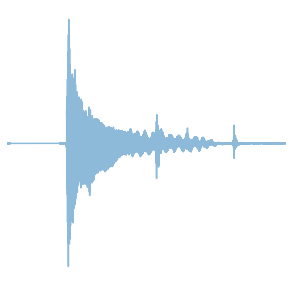

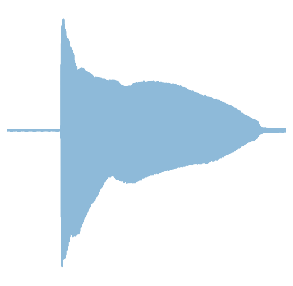

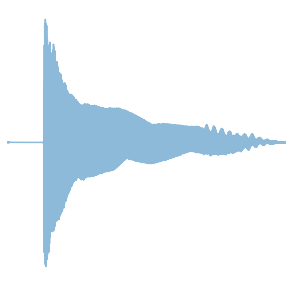

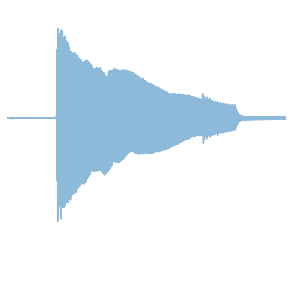

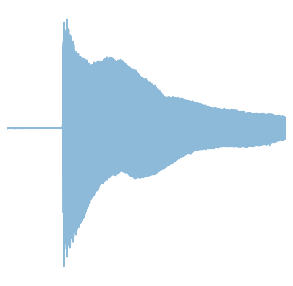

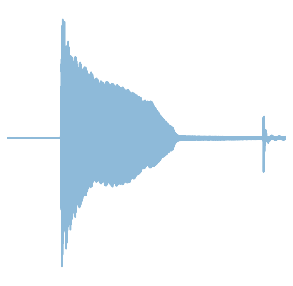

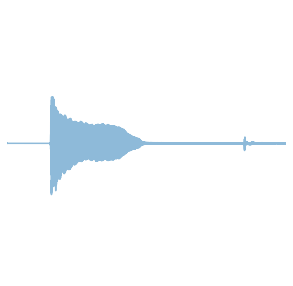

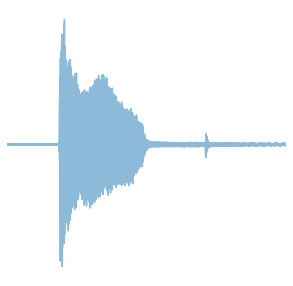

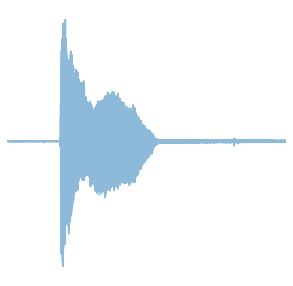

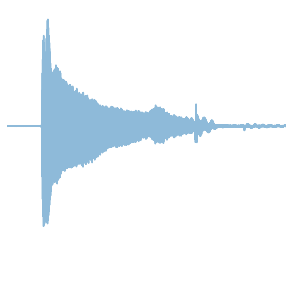

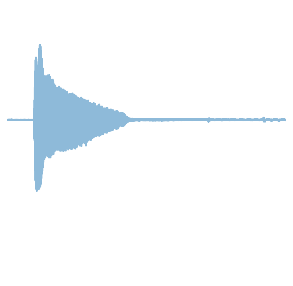

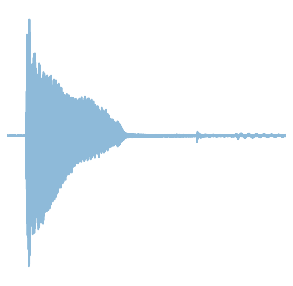

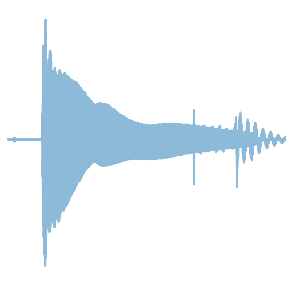

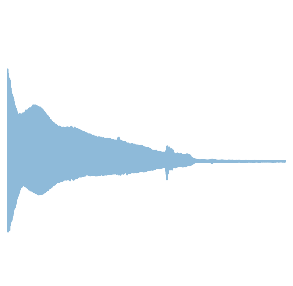

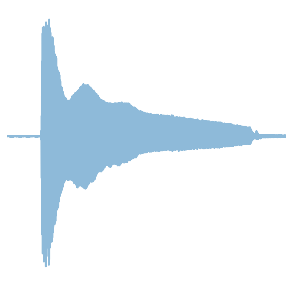

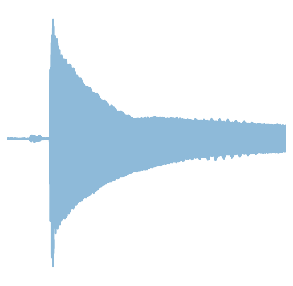

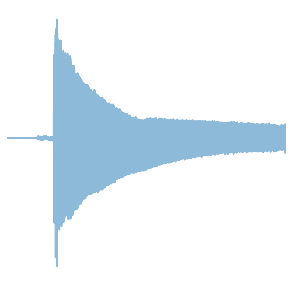

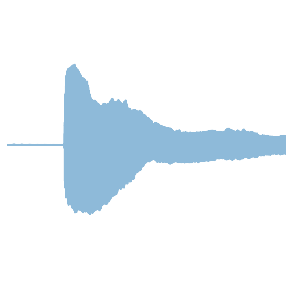

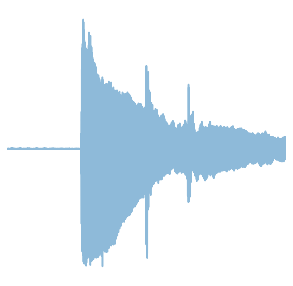

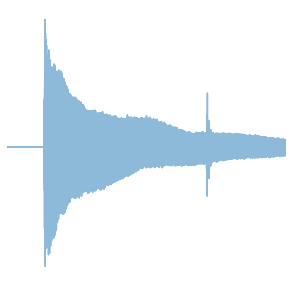

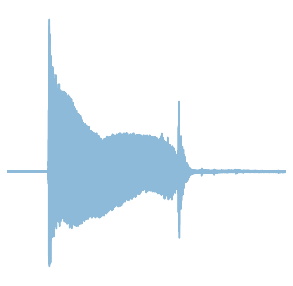

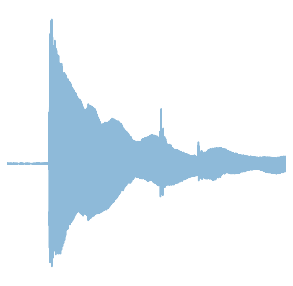

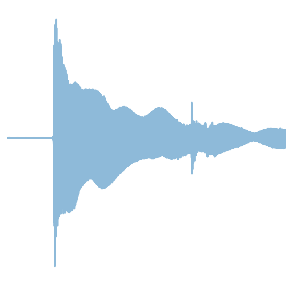

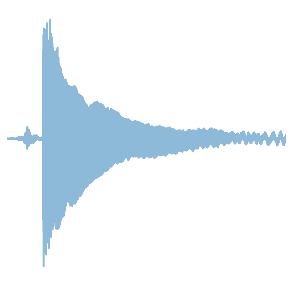

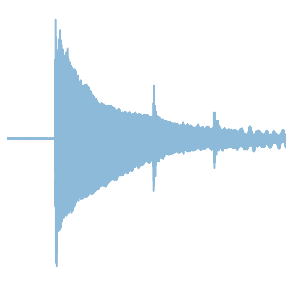

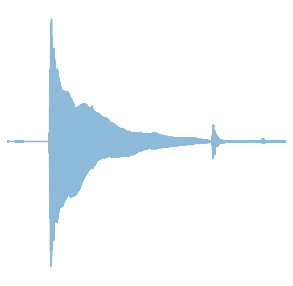

In [12]:

newArr = []


for filen in glob.iglob(f'{directory}/*'):


  # Open wav file and read frames as bytes
  sf_filewave = wave.open(filen, 'r')
  signal_sf = sf_filewave.readframes(-1)# Convert audio bytes to integers
  soundwave_sf = np.frombuffer(signal_sf, dtype='int16')# Get the sound wave frame rate
  framerate_sf = sf_filewave.getframerate()# Find the sound wave timestamps


  time_sf = np.linspace(start=0,
                        stop=len(soundwave_sf)/framerate_sf,
                        num=len(soundwave_sf))# Set up plot
  f, ax = plt.subplots(figsize=(5, 5))# Setup the title and axis titles

  
  #plt.title('Amplitude over Time')
  #plt.ylabel('Amplitude')
  #plt.xlabel('Time (seconds)')# Add the audio data to the plot
  
  dog = str(filen[80:])
  
  newArr.append(dog)


  # Add the audio data to the plot
  ax = plt.plot(time_sf, soundwave_sf, label = dog, alpha=0.5)
  
  plt.xlim([5, 15])

  #plt.legend()
  plt.axis('off')

  out = "/content/drive/My Drive/note_classification_project/image_converted/" + dog
  #plt.savefig(out)

  #plt.show()



In [13]:
newArr

['3G2',
 '6E1',
 '6E2',
 '6F1',
 '6F2',
 '6F#1',
 '6F#2',
 '6G1',
 '6G2',
 '5A1',
 '5A2',
 '5Bb1',
 '5Bb2',
 '5B1',
 '5B2',
 '5C1',
 '5C2',
 '4D1',
 '4D2',
 '4Eb1',
 '4Eb2',
 '4E1',
 '4E2',
 '4F1',
 '4F2',
 '3G1']

In [14]:
newArr2 = []
for i in range(len(newArr)):
  newArr2.append(newArr[i][:-1])

In [15]:
X_data = []
imgdirectory = "/content/drive/My Drive/note_classification_project/image_converted"
for myfile in glob.iglob(f'{imgdirectory}/*'):
    image = cv2.imread(myfile)
    X_data.append(image)

In [16]:
X_data2 = np.array(X_data)

In [17]:
y_data = np.array(newArr2)

In [18]:
X_data2.shape

(26, 360, 360, 3)

In [19]:
y_data.shape

(26,)

In [20]:
y_data

array(['3G', '6E', '6E', '6F', '6F', '6F#', '6F#', '6G', '6G', '5A', '5A',
       '5Bb', '5Bb', '5B', '5B', '5C', '5C', '4D', '4D', '4Eb', '4Eb',
       '4E', '4E', '4F', '4F', '3G'], dtype='<U3')

In [21]:
def find_target(X):
  
  le = preprocessing.LabelEncoder()
  target2 = le.fit_transform(X)

  return target2

target = find_target(y_data)
target

array([ 0,  9,  9, 10, 10, 11, 11, 12, 12,  5,  5,  7,  7,  6,  6,  8,  8,
        1,  1,  3,  3,  2,  2,  4,  4,  0])

In [22]:
num_to_note = {0:"3G",9:"6E",10:"6F",11:"6F#",12:"6G",5:"5A",7:"5Bb",6:"5B",8:"5C",1:"4D",3:"4Eb",2:"4E",4:"4F"}

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_data2, target, test_size=0.1, random_state=42,shuffle=True)

In [24]:
X_train.shape

(23, 360, 360, 3)

In [192]:
model=Sequential()

model.add(Conv2D(filters=1,kernel_size=2,activation="relu",input_shape=(360,360,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=4,kernel_size=2,activation ="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=16,kernel_size=2,activation ="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32,kernel_size=2,activation ="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten())
model.add(Dense(13,activation="softmax"))


model.compile(optimizer='adamax',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1/1 [==============================] - 1s 933ms/step - loss: 265.0739 - accuracy: 0.0870


In [195]:
y_pred = model.predict(X_test)

for i in range(len(y_pred)):
  a = y_pred[i]
  out = np.argmax(a)
  fin = num_to_note.get(out)
  print(fin)
  #print(y_pred)

print("_____________")

for i in range(len(y_test)):
  arg = y_test[i]
  print(num_to_note.get(arg))

6G
6G
6G
_____________
6G
5C
3G
